# Eval 8: Essential Gene Prediction

**Biological question**: Do the learned gene embeddings encode functional importance?

**Setup**: Train a linear probe on frozen gene embeddings to predict gene essentiality scores from DepMap.

**Metrics**: Pearson/Spearman correlation, AUROC for essential vs non-essential classification

**Story**: If the model learns which genes are critical for cell viability, it suggests understanding of the functional hierarchy.

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import subprocess
import json
import requests
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from eval_common import get_paths, load_biojepa_model, update_eval_report

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

paths = get_paths()
biojepa = load_biojepa_model(paths, device)

Using cpu
<All keys matched successfully>


## Load DepMap Data

Download CRISPR gene effect scores from DepMap. Negative scores indicate essential genes (cell death when knocked out).

In [3]:
depmap_dir = paths['data_dir'] / 'depmap'
depmap_dir.mkdir(exist_ok=True)
crispr_file = depmap_dir / 'CRISPRGeneEffect.csv'

if not crispr_file.exists():
    print('Fetching file list from DepMap API...')
    files_df = pd.read_csv('https://depmap.org/portal/api/download/files')
    
    crispr_rows = files_df[files_df['filename'] == 'CRISPRGeneEffect.csv'].copy()
    crispr_rows = crispr_rows.sort_values('release_date', ascending=False)
    print(f'Found {len(crispr_rows)} CRISPRGeneEffect.csv files, newest: {crispr_rows.iloc[0]["release_date"]}')
    
    crispr_url = crispr_rows.iloc[0]['url']
    print(f'Downloading from: {crispr_url[:80]}...')
    
    subprocess.run(['wget', '-O', str(crispr_file), crispr_url], check=True)
    print('Download complete!')
else:
    print(f'Using cached file: {crispr_file}')

crispr_file

Using cached file: /Users/djemec/data/jepa/v0_4/depmap/CRISPRGeneEffect.csv


PosixPath('/Users/djemec/data/jepa/v0_4/depmap/CRISPRGeneEffect.csv')

In [4]:
print('Loading DepMap CRISPR data...')
crispr_df = pd.read_csv(crispr_file, index_col=0)
print(f'CRISPR data shape: {crispr_df.shape}')
print(f'Index examples: {list(crispr_df.index[:5])}')

Loading DepMap CRISPR data...
CRISPR data shape: (1186, 18435)
Index examples: ['ACH-000015', 'ACH-000045', 'ACH-000094', 'ACH-000096', 'ACH-000099']


In [5]:
# K562 DepMap model ID is ACH-000551
K562_MODEL_ID = 'ACH-000551'

if K562_MODEL_ID in crispr_df.index:
    k562_idx = K562_MODEL_ID
    print(f'Found K562 with model ID: {k562_idx}')
else:
    k562_matches = [idx for idx in crispr_df.index if 'K562' in str(idx).upper()]
    if k562_matches:
        k562_idx = k562_matches[0]
        print(f'Found K562 by name search: {k562_idx}')
    else:
        raise ValueError('Could not find K562 in CRISPR data. Available indices:', crispr_df.index[:10].tolist())

Found K562 with model ID: ACH-000551


In [6]:
k562_scores = crispr_df.loc[k562_idx]

print(f'K562 gene scores: {len(k562_scores)} genes')
print(f'Score range: [{k562_scores.min():.3f}, {k562_scores.max():.3f}]')
print(f'Mean: {k562_scores.mean():.3f}, Std: {k562_scores.std():.3f}')

K562 gene scores: 18435 genes
Score range: [-4.682, 0.769]
Mean: -0.148, Std: 0.437


In [7]:
depmap_gene_to_score = {}
for col in k562_scores.index:
    gene_name = col.split(' ')[0].upper()
    depmap_gene_to_score[gene_name] = k562_scores[col]

print(f'Parsed {len(depmap_gene_to_score)} gene scores')
print(f'Example genes: {list(depmap_gene_to_score.keys())[:10]}')

Parsed 18435 gene scores
Example genes: ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC']


## Extract Gene Embeddings and Match to DepMap

In [8]:
with open(paths['data_dir'] / 'gene_names.json') as f:
    gene_names = json.load(f)

gene_embeddings = biojepa.student.gene_embeddings.detach().cpu().numpy()
print(f'Gene embeddings shape: {gene_embeddings.shape}')
print(f'Gene names: {len(gene_names)}')

Gene embeddings shape: (5000, 8)
Gene names: 5000


In [9]:
matched_indices = []
matched_scores = []
matched_names = []

for idx, gene in enumerate(gene_names):
    gene_upper = gene.upper()
    if gene_upper in depmap_gene_to_score:
        matched_indices.append(idx)
        matched_scores.append(depmap_gene_to_score[gene_upper])
        matched_names.append(gene_upper)

matched_embeddings = gene_embeddings[matched_indices]
matched_scores = np.array(matched_scores)

print(f'Matched genes: {len(matched_indices)} / {len(gene_names)} ({100*len(matched_indices)/len(gene_names):.1f}%)')
print(f'Embeddings shape: {matched_embeddings.shape}')
print(f'Scores shape: {matched_scores.shape}')

Matched genes: 4541 / 5000 (90.8%)
Embeddings shape: (4541, 8)
Scores shape: (4541,)


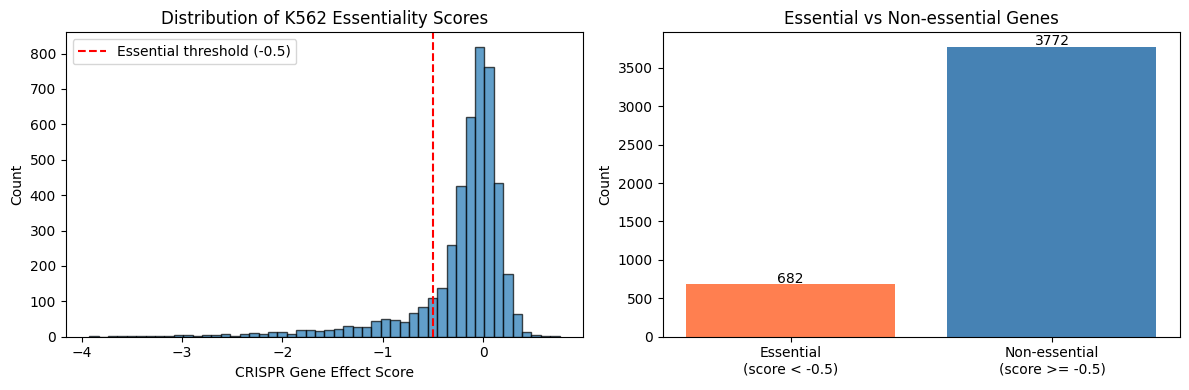

Essential genes (score < -0.5): 682 (15.0%)
Non-essential genes: 3772 (83.1%)


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(matched_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=-0.5, color='red', linestyle='--', label='Essential threshold (-0.5)')
axes[0].set_xlabel('CRISPR Gene Effect Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of K562 Essentiality Scores')
axes[0].legend()

n_essential = np.sum(matched_scores < -0.5)
n_non_essential = np.sum(matched_scores >= -0.5)
axes[1].bar(['Essential\n(score < -0.5)', 'Non-essential\n(score >= -0.5)'], 
            [n_essential, n_non_essential], color=['coral', 'steelblue'])
axes[1].set_ylabel('Count')
axes[1].set_title('Essential vs Non-essential Genes')
for i, v in enumerate([n_essential, n_non_essential]):
    axes[1].text(i, v + 20, str(v), ha='center')

plt.tight_layout()
plt.show()

print(f'Essential genes (score < -0.5): {n_essential} ({100*n_essential/len(matched_scores):.1f}%)')
print(f'Non-essential genes: {n_non_essential} ({100*n_non_essential/len(matched_scores):.1f}%)')

## Train Linear Probe

Train a simple linear model on frozen gene embeddings to predict essentiality scores.

In [11]:
# Check for NaN/inf in data
print(f'NaN in embeddings: {np.isnan(matched_embeddings).sum()}')
print(f'NaN in scores: {np.isnan(matched_scores).sum()}')
print(f'Inf in embeddings: {np.isinf(matched_embeddings).sum()}')
print(f'Inf in scores: {np.isinf(matched_scores).sum()}')

# Filter out any rows with NaN/inf
valid_mask = ~(np.isnan(matched_scores) | np.isinf(matched_scores) | np.isnan(matched_embeddings).any(axis=1) | np.isinf(matched_embeddings).any(axis=1))
clean_embeddings = matched_embeddings[valid_mask]
clean_scores = matched_scores[valid_mask]
clean_names = [n for n, v in zip(matched_names, valid_mask) if v]

print(f'Valid samples after filtering: {len(clean_embeddings)} / {len(matched_embeddings)}')

X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    clean_embeddings, clean_scores, clean_names, 
    test_size=0.2, random_state=42
)

print(f'Train: {len(X_train)} genes')
print(f'Test: {len(X_test)} genes')

NaN in embeddings: 0
NaN in scores: 87
Inf in embeddings: 0
Inf in scores: 0
Valid samples after filtering: 4454 / 4541
Train: 3563 genes
Test: 891 genes


In [12]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x).squeeze(-1)

probe = LinearProbe(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(probe.parameters(), lr=1e-3)
criterion = nn.MSELoss()

X_train_t = torch.from_numpy(X_train).float().to(device)
y_train_t = torch.from_numpy(y_train).float().to(device)
X_test_t = torch.from_numpy(X_test).float().to(device)
y_test_t = torch.from_numpy(y_test).float().to(device)

# Verify tensors are clean
print(f'X_train_t has NaN: {torch.isnan(X_train_t).any().item()}')
print(f'y_train_t has NaN: {torch.isnan(y_train_t).any().item()}')

for epoch in range(500):
    probe.train()
    optimizer.zero_grad()
    pred = probe(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(probe.parameters(), 1.0)
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        probe.eval()
        with torch.no_grad():
            test_pred = probe(X_test_t)
            test_loss = criterion(test_pred, y_test_t)
        print(f'Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Test Loss = {test_loss.item():.4f}')

X_train_t has NaN: False
y_train_t has NaN: False
Epoch 100: Train Loss = 0.3998, Test Loss = 0.3236
Epoch 200: Train Loss = 0.3341, Test Loss = 0.2648
Epoch 300: Train Loss = 0.2992, Test Loss = 0.2352
Epoch 400: Train Loss = 0.2824, Test Loss = 0.2223
Epoch 500: Train Loss = 0.2746, Test Loss = 0.2172


## Evaluate Predictions

In [13]:
probe.eval()
with torch.no_grad():
    y_pred_train = probe(X_train_t).cpu().numpy()
    y_pred_test = probe(X_test_t).cpu().numpy()

pearson_train, _ = pearsonr(y_train, y_pred_train)
pearson_test, _ = pearsonr(y_test, y_pred_test)
spearman_train, _ = spearmanr(y_train, y_pred_train)
spearman_test, _ = spearmanr(y_test, y_pred_test)

print('REGRESSION METRICS')
print(f'Train Pearson:  {pearson_train:.4f}')
print(f'Test Pearson:   {pearson_test:.4f}')
print(f'Train Spearman: {spearman_train:.4f}')
print(f'Test Spearman:  {spearman_test:.4f}')

REGRESSION METRICS
Train Pearson:  0.2047
Test Pearson:   0.1776
Train Spearman: 0.1319
Test Spearman:  0.1276


In [14]:
ESSENTIAL_THRESHOLD = -0.5

y_train_binary = (y_train < ESSENTIAL_THRESHOLD).astype(int)
y_test_binary = (y_test < ESSENTIAL_THRESHOLD).astype(int)

auroc_train = roc_auc_score(y_train_binary, -y_pred_train)
auroc_test = roc_auc_score(y_test_binary, -y_pred_test)

print('\nCLASSIFICATION METRICS (Essential vs Non-essential)')
print(f'Train AUROC: {auroc_train:.4f}')
print(f'Test AUROC:  {auroc_test:.4f}')


CLASSIFICATION METRICS (Essential vs Non-essential)
Train AUROC: 0.6039
Test AUROC:  0.6140


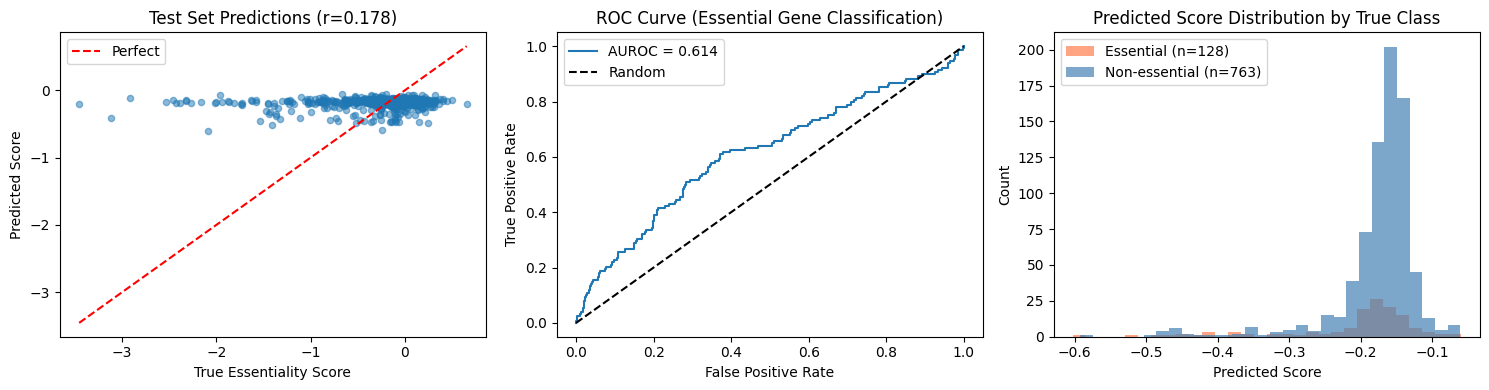

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect')
axes[0].set_xlabel('True Essentiality Score')
axes[0].set_ylabel('Predicted Score')
axes[0].set_title(f'Test Set Predictions (r={pearson_test:.3f})')
axes[0].legend()

fpr, tpr, _ = roc_curve(y_test_binary, -y_pred_test)
axes[1].plot(fpr, tpr, label=f'AUROC = {auroc_test:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (Essential Gene Classification)')
axes[1].legend()

essential_mask = y_test < ESSENTIAL_THRESHOLD
axes[2].hist(y_pred_test[essential_mask], bins=30, alpha=0.7, label=f'Essential (n={essential_mask.sum()})', color='coral')
axes[2].hist(y_pred_test[~essential_mask], bins=30, alpha=0.7, label=f'Non-essential (n={(~essential_mask).sum()})', color='steelblue')
axes[2].set_xlabel('Predicted Score')
axes[2].set_ylabel('Count')
axes[2].set_title('Predicted Score Distribution by True Class')
axes[2].legend()

plt.tight_layout()
plt.show()

### Top Predicted Essential Genes

In [16]:
test_results = pd.DataFrame({
    'gene': names_test,
    'true_score': y_test,
    'pred_score': y_pred_test,
    'true_essential': y_test < ESSENTIAL_THRESHOLD
})
test_results['pred_rank'] = test_results['pred_score'].rank()
test_results['true_rank'] = test_results['true_score'].rank()

print('Top 15 Predicted Essential Genes (lowest predicted scores):')
top_pred = test_results.nsmallest(15, 'pred_score')
print(top_pred[['gene', 'pred_score', 'true_score', 'true_essential']].to_string(index=False))

Top 15 Predicted Essential Genes (lowest predicted scores):
     gene  pred_score  true_score  true_essential
    AURKA   -0.602050   -2.089135            True
    ZWINT   -0.591891   -0.238424           False
   INCENP   -0.514473   -1.408968            True
  DEPDC1B   -0.492227    0.245999           False
    BUB1B   -0.487047   -0.522461            True
     EXO1   -0.474362   -0.364206           False
    CEP55   -0.470682   -0.136500           False
   SHCBP1   -0.469441    0.153184           False
ARHGAP11A   -0.468465   -0.094906           False
   DLGAP5   -0.466877   -0.155805           False
    NEMP1   -0.463618   -0.066084           False
    SPC25   -0.463277   -1.539974            True
    FANCI   -0.460221   -0.429813           False
    CENPU   -0.454825   -0.144414           False
   DEPDC1   -0.452678   -0.708102            True


---
## Summary

In [17]:
print('='*70)
print('EVAL 8: ESSENTIAL GENE PREDICTION - RESULTS')
print('='*70)
print()
print('CONFIGURATION')
print(f'  Matched genes: {len(matched_indices)}')
print(f'  Train/Test split: {len(X_train)}/{len(X_test)}')
print(f'  Essential genes in test: {y_test_binary.sum()} ({100*y_test_binary.mean():.1f}%)')
print()
print('REGRESSION METRICS')
print(f'  Pearson r (test):  {pearson_test:.4f}')
print(f'  Spearman r (test): {spearman_test:.4f}')
print()
print('CLASSIFICATION METRICS')
print(f'  AUROC (test): {auroc_test:.4f}')
print()
print('INTERPRETATION')
print('-'*40)
if pearson_test > 0.3 and auroc_test > 0.65:
    print('GOOD: Gene embeddings encode essentiality information.')
elif pearson_test > 0.1 or auroc_test > 0.55:
    print('WEAK: Some essentiality signal present but limited.')
else:
    print('NO SIGNAL: Gene embeddings do not predict essentiality.')

EVAL 8: ESSENTIAL GENE PREDICTION - RESULTS

CONFIGURATION
  Matched genes: 4541
  Train/Test split: 3563/891
  Essential genes in test: 128 (14.4%)

REGRESSION METRICS
  Pearson r (test):  0.1776
  Spearman r (test): 0.1276

CLASSIFICATION METRICS
  AUROC (test): 0.6140

INTERPRETATION
----------------------------------------
WEAK: Some essentiality signal present but limited.


In [18]:
update_eval_report('eval_8_essential_genes', {
    'config': {
        'matched_genes': len(matched_indices),
        'train_genes': len(X_train),
        'test_genes': len(X_test),
        'essential_threshold': ESSENTIAL_THRESHOLD,
        'depmap_source': 'depmap-downloader (latest)'
    },
    'regression': {
        'pearson_train': float(pearson_train),
        'pearson_test': float(pearson_test),
        'spearman_train': float(spearman_train),
        'spearman_test': float(spearman_test)
    },
    'classification': {
        'auroc_train': float(auroc_train),
        'auroc_test': float(auroc_test),
        'n_essential_test': int(y_test_binary.sum()),
        'n_non_essential_test': int((~y_test_binary.astype(bool)).sum())
    }
})

Updated eval_report.json
